# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.integrate import quad

In [152]:
df = pd.read_csv(
    "Lifespans_ITP1.csv",
    skiprows=0,
    sep=";",
    index_col=[0, 1],
    skipfooter=0,
    engine="python",
    decimal=",",
)
df

site sex       id     group Rx(ppm) age_initiation(mo)  \
population cohort                                                          
UM-HET3    C2004   TJL   m  JL00005  4-OH-PBN     315                4.0   
           C2004   TJL   m  JL00006  4-OH-PBN     315                4.0   
           C2004   TJL   m  JL00007  4-OH-PBN     315                4.0   
           C2004   TJL   f  JL00095  4-OH-PBN     315                4.0   
           C2004   TJL   f  JL00096  4-OH-PBN     315                4.0   
...                ...  ..      ...       ...     ...                ...   
           C2017    UT   m  UT10744       Syr     300                5.0   
           C2017    UT   m  UT10745       Syr     300                5.0   
           C2017    UT   m  UT10783       Syr     300                5.0   
           C2017    UT   m  UT10784       Syr     300                5.0   
           C2017    UT   m  UT10785       Syr     300                5.0   

                  status  dead  age(days)  
population cohort                          
UM-HET3    C2004    dead     1        896  
           C2004    dead     1       1077  
           C2004    dead     1        790  
           C2004    dead     1        823  
           C2004    dead     1        601  
...                  ...   ...        ...  
           C2017    dead     1        289  
           C2017    dead     1        662  
           C2017    dead     1        440  
           C2017    dead     1        342  
           C2017    dead     1        754  

[27574 rows x 9 columns]

In [153]:
control_group = df.loc[df['group'] == "Control"]
control_group

site sex       id    group Rx(ppm) age_initiation(mo)  \
population cohort                                                         
UM-HET3    C2004   TJL   m  JL00032  Control       0                NaN   
           C2004   TJL   m  JL00033  Control       0                NaN   
           C2004   TJL   m  JL00034  Control       0                NaN   
           C2004   TJL   m  JL00045  Control       0                NaN   
           C2004   TJL   m  JL00046  Control       0                NaN   
...                ...  ..      ...      ...     ...                ...   
           C2017    UT   m  UT10915  Control       0                NaN   
           C2017    UT   m  UT10916  Control       0                NaN   
           C2017    UT   m  UT11153  Control       0                NaN   
           C2017    UT   m  UT11154  Control       0                NaN   
           C2017    UT   m  UT11155  Control       0                NaN   

                  status  dead  age(days)  
population cohort                          
UM-HET3    C2004    dead     1        916  
           C2004    dead     1       1099  
           C2004    dead     1        666  
           C2004    dead     1        957  
           C2004    dead     1        553  
...                  ...   ...        ...  
           C2017    dead     1        215  
           C2017    dead     1        625  
           C2017    dead     1        312  
           C2017    dead     1        307  
           C2017    dead     1        773  

[7815 rows x 9 columns]

In [154]:
## Mutate Data to calculate Mortality Rate

# Running Day Col
days = {'Day': range(1, int(control_group['age(days)'].max() + 1))}
mortality_rate_df = pd.DataFrame(days)
# Init Population Col
mortality_rate_df["Population"] = len(control_group)
# Sum of Deaths for every day 
deaths = control_group.groupby(age_column)[dead_column].sum()
mortality_rate_df['Deaths'] = mortality_rate_df['Day'].map(deaths).fillna(0).astype(int)
## Decrease Population for all occured deaths
mortality_rate_df['Population'] = mortality_rate_df['Population'] - mortality_rate_df['Deaths'].cumsum()
## Filter out days where death is 0
mortality_rate_df = mortality_rate_df[mortality_rate_df['Deaths'] != 0]
mortality_rate_df

,Day,Population,Deaths
26,27,7814,1
50,51,7812,2
53,54,7811,1
87,88,7809,2
122,123,7808,1
...,...,...,...
1339,1340,453,1
1357,1358,452,1
1358,1359,451,1
1395,1396,450,1


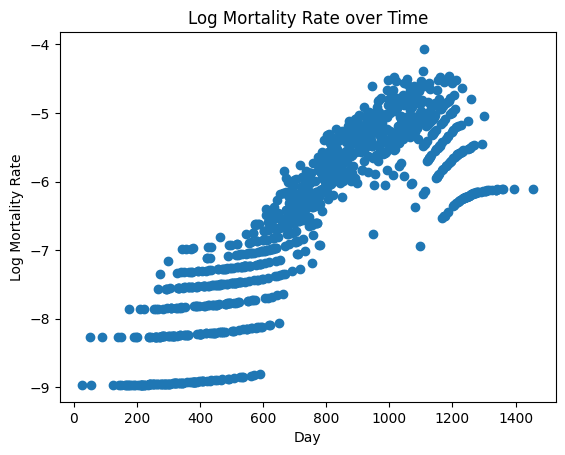

In [155]:
## Log Mortality Rate of Control Group

# Calculate log mortality rate
mortality_rate_df['MortalityRate'] = mortality_rate_df['Deaths'] / mortality_rate_df['Population']
mortality_rate_df['LogMortalityRate'] = mortality_rate_df['MortalityRate'].apply(lambda x: np.log(x))
# Plotting
plt.scatter(mortality_rate_df['Day'], mortality_rate_df['LogMortalityRate'])
plt.xlabel('Day')
plt.ylabel('Log Mortality Rate')
plt.title('Log Mortality Rate over Time')
plt.show()

In [156]:
#gompertz law functions


##param: x = age or time
##param: alpha = baseline mortality
##param: beta = rate of mortality increase
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)
def gompertz_cdf(x, alpha, beta):
    cdf, _ = quad(lambda t: gompertz(t, alpha, beta), 0, x)
    return cdf

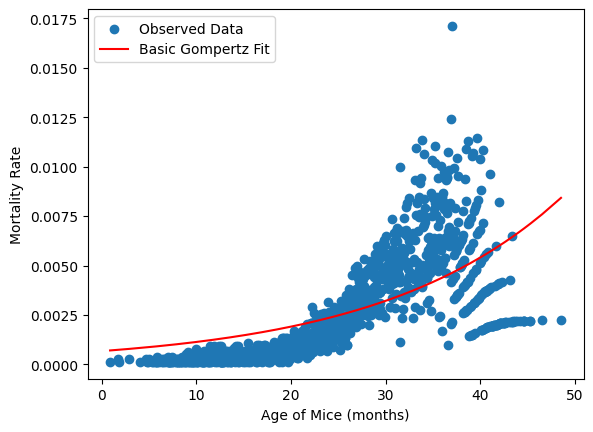

Fitted Parameters:
Alpha: 0.0006757858136580071
Beta: 0.0519763901466279


In [157]:
ages_in_months = mortality_rate_df['Day'] / 30
mortality_rates = mortality_rate_df['MortalityRate']

# Provide initial parameter estimates
initial_params = [0.001, 0.1]

# Fit the basic Gompertz model to the data
params, covariance = curve_fit(gompertz, ages_in_months, mortality_rates, p0=initial_params)
# Extract the fitted parameters
alpha_fit_mice, beta_fit_mice = params

# Generate predicted mortality rates using the fitted parameters
predicted_mortality = gompertz(ages_in_months, alpha_fit_mice, beta_fit_mice)

# Plot the results
plt.scatter(ages_in_months, mortality_rates, label='Observed Data')
plt.plot(ages_in_months, predicted_mortality, label='Basic Gompertz Fit', color='red')
plt.xlabel('Age of Mice (months)')
plt.ylabel('Mortality Rate')
plt.legend()
plt.show()

print("Fitted Parameters:")
print("Alpha:", alpha_fit_mice)
print("Beta:", beta_fit_mice)

In [158]:
r_squared = r2_score(mortality_rates, predicted_mortality)
mse = mean_squared_error(mortality_rates, predicted_mortality)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')


R-squared: 0.43558168741467673
Mean Squared Error: 3.936579629474498e-06


In [159]:
## Import and curate Human Data
human_mortality_df = pd.read_excel("./Lifespans_Humans.xlsx")
## Population of Germany in 2020: 83.16 milion
population = 83.16 * 1e6
## Add Column Population
human_mortality_df["Population"] = population
## Decrease Population for all occured deaths
human_mortality_df['Population'] = human_mortality_df['Population'] - human_mortality_df['Total'].cumsum()
human_mortality_df

,Year,Age,Total,Population
0,2020,0,2373.00,83157627.00
1,2020,1,156.00,83157471.00
2,2020,2,91.01,83157379.99
3,2020,3,81.00,83157298.99
4,2020,4,79.00,83157219.99
...,...,...,...,...
106,2020,106,139.17,82174550.82
107,2020,107,66.31,82174484.51
108,2020,108,31.23,82174453.28
109,2020,109,14.52,82174438.76


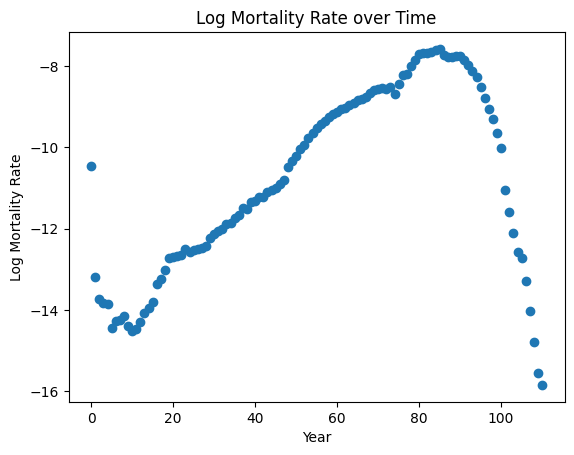

In [160]:
## Log Mortality Rate of Humans in 2020

# Calculate log mortality rate
human_mortality_df['MortalityRate'] = human_mortality_df['Total'] / human_mortality_df['Population']
human_mortality_df['LogMortalityRate'] = human_mortality_df['MortalityRate'].apply(lambda x: np.log(x))
# Plotting
plt.scatter(human_mortality_df['Age'], human_mortality_df['LogMortalityRate'])
plt.xlabel('Year')
plt.ylabel('Log Mortality Rate')
plt.title('Log Mortality Rate over Time')
plt.show()

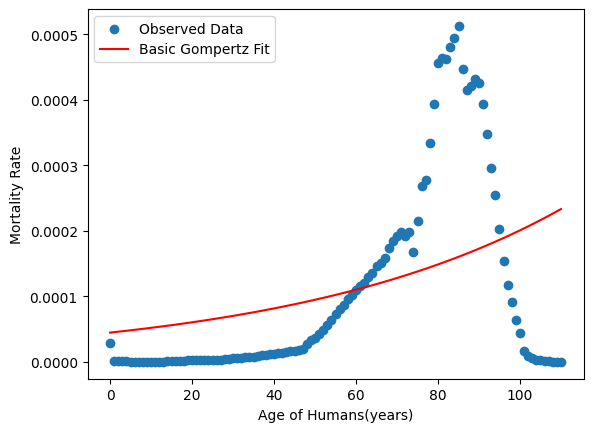

Fitted Parameters:
Alpha: 4.4908549431747255e-05
Beta: 0.014981746905186765


In [161]:
# Fit Human Data to Gompertz

# Provide initial parameter estimates
initial_params = [0.001, 0.2]
ages = human_mortality_df['Age']
mortality_rates = human_mortality_df['MortalityRate']

# Fit the basic Gompertz model to the data
params, covariance = curve_fit(gompertz, ages, mortality_rates, p0=initial_params)
# Extract the fitted parameters
alpha_fit_humans, beta_fit_humans = params

# Generate predicted mortality rates using the fitted parameters
predicted_mortality = gompertz(ages, alpha_fit_humans, beta_fit_humans)

# Plot the results
plt.scatter(ages, mortality_rates, label='Observed Data')
plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
plt.xlabel('Age of Humans(years)')
plt.ylabel('Mortality Rate')
plt.legend()
plt.show()

print("Fitted Parameters:")
print("Alpha:", alpha_fit_humans)
print("Beta:", beta_fit_humans)

In [162]:
# Discretize the age range for humans
ages_human = np.linspace(0, 100, num=1000)
# Compute the CDF for humans
cdf_human = [gompertz_cdf(age, alpha_fit_humans, beta_fit_humans) for age in ages_human]

# Discretize the age range for mice
ages_mice = np.linspace(0, 50, num=1000)
# Compute the CDF for mice
cdf_mice = [gompertz_cdf(age, alpha_fit_mice, beta_fit_mice) for age in ages_mice]

# Ensure that CDFs are non-zero before computing the KL divergence
cdf_human = np.maximum(cdf_human, np.finfo(float).eps)
cdf_mice = np.maximum(cdf_mice, np.finfo(float).eps)

# Compute the KL divergence
kl_divergence = np.sum(cdf_mice * np.log(cdf_mice / cdf_human))

print(f"KL Divergence: {kl_divergence}")


KL Divergence: 125.08406505200078
